In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import squarify
import seaborn as sns


from collections import Counter
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [2]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='alena99', api_key='Vuvfvee2phTjLJm2tEEZ')

# Описание данных

### База данных по оцениванию студентов (+ характеристики обучающихся)

### А - описание набора данных

В качестве зависимой переменной была выбрана оценка по математике (`math score`, срез - индивид). `Исследовательский вопрос`: каким образом характеристики индивида влияют на его оценку по математике?

In [3]:
df_student = pd.read_csv("StudentsPerformance.csv")

В базе данных содержится 8 переменных по 1000 наблюдений (строк) для каждой. База данных была взята с сайта `kaggle` пользователем `SPScientist` (India).

In [4]:
df_student.head(3)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93


In [5]:
df_student.isna().sum() # нет пропущенных значений

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

### B - Описание отношений между исследуемыми переменными

Мы предполагаем исследование влияния характеристик индивидов на их успеваемость по математике. Предполагаем после предварительного анализа сократить список характеристик до влиятельных факторов на отклик. В основном предполагаем положительную взаимосвязь между зависимой и независимыми переменными (что будет рассмотрено и доказано ниже: посредством корреляционной матрицы и графически).

### C - Описание перменных

##### Независимые переменные:

* `Gender`: пол респондента - female/male - категориальная(бинарная);
* `Race/ethnicity`: этническая группа респондента - group A/ group B/ group C/ group D/ group E - категориальная (номинальная);
* `Parental level of education`: уровень образования - Associates degree/ bachelor's degree/ high school/ master's degree/ some college/ some high school - категориальная (порядковая);
* `Lunch`: free/reduced/  standard - категориальная (бинарная);
* `Test preparation course`: уровень подготовки к тесту - completed/ none - категориальная (бинарная).

##### Зависимая переменная:
* `math score`: оценка за математику - количественная (дискретная).

##### Дополнительные переменные:
* `reading score`: оценка за чтение - количественная (дискретная);
* `writing score`: оценка за письмо - количественная (дискретная).

In [6]:
df_student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [7]:
df_student.describe() # смотрим на описательные статистки данных

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Корреляция между зависимой переменной и дополнительными (высокая положительная).

In [8]:
df_student.corr() 

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


### Создание тренировочных и тестовых выборок

В Х передадим все независимые переменные, а в у пока положим значения зависимой переменной и дополнительных.

In [9]:
X_st = df_student[df_student.columns[:5]]
y_st = df_student[df_student.columns[5:]]

Разделим выборку на тестовую и тренировочную в отношении 1 к 3.

In [10]:
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X_st, y_st, test_size = 0.33, 
                                                        random_state = 42)

Проверяем соотношение выборок.

In [11]:
print("Длина тренирововчного датасета -", len(X_train_st), "\t ", 
      "Длина тестового датасета -", len(y_test_st)
     )

Длина тренирововчного датасета - 670 	  Длина тестового датасета - 330


# Разведывательный анализ данных (на тренировочной выборке)

### C - Преобразования данных

Предполагаем, что задачу проще решить через классификатор, предсказывая на основании характристик индивида его шкалированную оценку по математике от 1 до 5. Для этого создадим функцию, которая преобразовывает дискретный отклик и категориальную переменную, где 1 - несдача математического теста, 2 - отличное прохождение теста.

In [12]:
def create_factor_y(y1, confines):
    y = y1.tolist()
    cat = pd.cut(y, confines).codes
    return cat + 1

Предерживаемся жесткого шкалирования оценок (где балл, ниже 60, считается несдачей), чтобы получить более-менее равномерные классы на тренировочной выборке. Зато 5 баллов можно получить за оценку от 86 до 100.

##### Шкалирование зависимой переменной первого датасета
* 1 балл: от 0 до 50;
* 2 балла: от 51 до 60;
* 3 балла: от 61 до 70;
* 4 балла: от 71 до 80;
* 5 баллов: от 86 до 100.

Восстановим индексацию (от 0 до длины тернировочного датасета).

In [13]:
def reset_indexes(data):
    data.index = pd.RangeIndex(len(data.index))
    data.index = range(len(data.index))
    return data

In [14]:
y_train_st = reset_indexes(y_train_st)
confines = [0, 50, 60, 70, 80, 100]

Реализуем функцию шкалирования зависимой переменной, получаем достаточно равномерные классы.

In [15]:
y_train_st_factor = create_factor_y(y_train_st['math score'], confines)
Counter(y_train_st_factor)

Counter({1: 91, 2: 132, 3: 175, 4: 147, 5: 125})

##### Изменение шкалирования образовательной степени:

Предполагаем, что бОльшее влияние на зависимую переменную будет иметь `уровень образования`, представленный в бинарном виде. Сведем все категории к образовнию со степенью и без нее.

* Без степени - None;
* Со степеью - Degree.

Создадим и применим функцию, которая итерируется по каждому значению `уровня образования` и там, где находит слово `degree`, присваивает ему степень, остальным значениям - `none`.

In [16]:
def create_list_of_degree_presence(column):
    degree_lst = []
    for i in column:
        if 'degree' in i:
            degree_lst.append('degree')
        else:
            degree_lst.append('none')
    return degree_lst

In [17]:
X_train_st = reset_indexes(X_train_st)
X_train_st['degree'] = create_list_of_degree_presence(X_train_st['parental level of education'])

C:\Users\Alii\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Получили ожидаемый результат.

In [18]:
X_train_st['degree'][:4]

0      none
1    degree
2      none
3      none
Name: degree, dtype: object

##### Конвертируем факторы в числовые значения для получения корреляционной матрицы и реализации моделей

Все независимые переменные представлены в базе данных типом `object`. Такой тип не позволит использовать переменные для построения корреляционной матрицы, обучения и тестирования моделей. Поэтому конвертнем их категории в числовые (вместо строкового).

In [19]:
X_train_st_copy = X_train_st.copy()
X_train_st_copy.columns.tolist()

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course',
 'degree']

Создадим конвертирующую функцию, последовательно ее применим к каждому столбцу в тренировочном датасете.

In [20]:
def string_to_numeric_factor(x):
    classnames, indices = np.unique(x, return_inverse=True)
    return indices

In [21]:
for i in X_train_st_copy.columns.tolist():
       X_train_st_copy[i] = string_to_numeric_factor(X_train_st_copy[i])

Посмотрим, что получилось, и опишем полученные переменные.

##### Числовые значения катtгорий для независимых переменных:
* `Gender`: female - 0, male - 1;
* `Race/ethnicity`: group A - 0, group B - 1, group C - 2, group D - 3, group E - 4;
* `Parental level of education`: Associates degree - 0, bachelor's degree - 1, high school - 2, master's degree - 3, some college - 4, some high school - 5;
* `Lunch`: free/reduced - 0, standard - 1;
* `Test preparation course`: completed - 0, none - 1;
* `Degree`: degree - 0, none - 1.

In [22]:
X_train_st_copy.head(4)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,degree
0,0,3,4,1,1,1
1,1,1,1,1,1,0
2,0,1,5,0,0,1
3,0,2,5,1,0,1


### B - Исследование отношений между зависимой переменной и факторами

##### Корреляционная матрица независимых переменных

Незвисимые переменные имеют слабо выраженный коэффициент корреляции по модулю, за исключением переменных `degree` и `parental level of education`, который имеют сльную положительную корреляцию (ввиду получения одной из другой).

In [23]:
X_train_st_copy.corr()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,degree
gender,1.000000,-0.009232,0.009805,0.011282,-0.045713,0.024413
race/ethnicity,-0.009232,1.000000,-0.048405,0.032111,-0.021361,-0.080832
parental level of education,0.009805,-0.048405,1.000000,0.030957,0.017011,0.783944
lunch,0.011282,0.032111,0.030957,1.000000,0.048616,0.038238
test preparation course,-0.045713,-0.021361,0.017011,0.048616,1.000000,0.052165
degree,0.024413,-0.080832,0.783944,0.038238,0.052165,1.000000


Создадим функцию, которая позволит проводить корреляционный анализ между переменными разных датасетов.
(Функция была взята с `Stack Overflow`)

In [24]:
def corr(df1, df2):
    n = len(df1)
    v1, v2 = df1.values, df2.values
    sums = np.multiply.outer(v2.sum(0), v1.sum(0))
    stds = np.multiply.outer(v2.std(0), v1.std(0))
    return pd.DataFrame((v2.T.dot(v1) - sums / n) / stds / n,
                        df2.columns, df1.columns)


##### Корреляционная матрица элементов зависимой переменной


Уже рассматривали данную матрицу выше (в первом задании).

In [25]:
df_student.corr()

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


##### Корреляционная матрица агрегированной, шкалированной зависимой переменной и факторов

В основном независимые переменные имеют положительную вазимосвязь с откликом. Наиболее ярко выраженные значения у отклика с переменными `race/ethnicity` и `lunch` (однако и их значения все равно малы). Из чего можно сделать вывод, что `y` достаточно слабо связан с `X`, что может повлиять на качество модели. В связи с чем перед обучением включим еще один признак - `reading score`, который сильно положительно связан с зависимой переменной и так же является характристикой индивида (его способности в чтении).

In [26]:
corr(X_train_st_copy, pd.DataFrame({'y': y_train_st_factor}))

,gender,race/ethnicity,parental level of education,lunch,test preparation course,degree
y,0.168156,0.21204,-0.029829,0.325151,-0.174338,-0.092218


##### Корреляционная матрица элементов зависимой переменной и факторов

Видим, что у трех дискретных переменных схожие корреляционные коэффициенты с независимыми переменными.

In [27]:
corr(X_train_st_copy, y_train_st)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,degree
math score,0.175447,0.207751,-0.037771,0.344768,-0.187208,-0.103822
reading score,-0.230601,0.141509,-0.051481,0.230266,-0.227691,-0.140353
writing score,-0.285386,0.162686,-0.072941,0.243115,-0.298825,-0.178216


##### Гистограммы отклика в зависимости от значения гендера

Для построения большинства графиков будем использовать нешкалированную зависимую переменную для более яркой и понятной визуализации.

Создадим общий датасет для тренировочной выборке (`Х` и `у`).

In [28]:
df_train_st = pd.concat([X_train_st.reset_index(drop=True),y_train_st.reset_index(drop=True)], axis=1)

Построим гистрограммы на одной плоскости отдельно для женщин и мужчин. Видим, что в целом распределение зависимой переменной очень схожи для обоих графиков, чуть скошены вправо. Среднее значение оценки за тест для женщин около 60, для мужчин - чуть выше. Влияние гендера достаточно слабое на зависимую переменную.

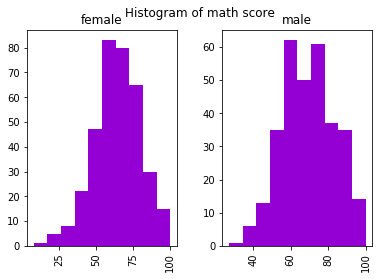

In [29]:
df_train_st['math score'].hist(by=df_train_st['gender'], color = 'darkviolet')
plt.suptitle("Histogram of math score")
plt.show()

##### Древовидная карта: зависимость отклика от уровня образования (для 6 категорий)

Посмотрим также, сколько сдавших тест по математике респондентов принадлежали к разным образовательным группам. Построим для данной задачи древовидную карту, для этого сначала сгруппируем базу по категориям независимой переменной и посчитаем частоту.

In [30]:
df_treemap = df_train_st.groupby('parental level of education')[['math score']].count()
df_treemap['parental level of education'] = df_treemap.index

In [31]:
df_treemap

,math score,parental level of education
parental level of education,,
associate's degree,150,associate's degree
bachelor's degree,85,bachelor's degree
high school,132,high school
master's degree,36,master's degree
some college,149,some college
some high school,118,some high school


Размер ячейки на графике отражает количество написавших тест для определенной образовательной группы. Больше всего студентов имели `associate's degree` или закончили `some college`, меньше всего - `master's degree`.

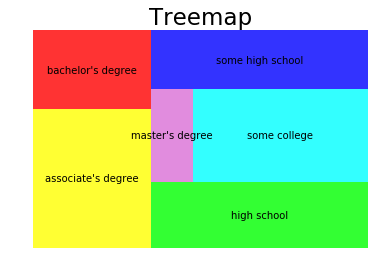

In [32]:
color = ["yellow", "red", "lime", "orchid", "cyan", "blue"]
squarify.plot(sizes=df_treemap['math score'], color = color, label=df_treemap['parental level of education'], alpha=.8 )
plt.title("Treemap",fontsize=23)
plt.axis('off')
plt.show()

##### Плотность отклика в зависимости от типа ланча

Построим график, отражающий плотность зависимой переменной на одной плоскости для наличия разного рода обеда. Те студенты, что брали стандартный ланч, как правило, сдали математический тест на более высокий бал (среднее значение чуть правее). То есть при переходе от 0 к 1 по ланчу средний балл по мат тесту увелчится.

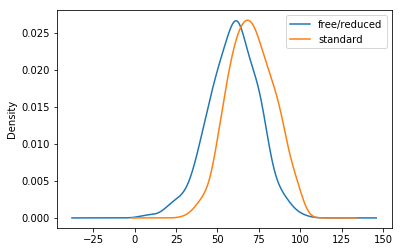

In [33]:
df_train_st.groupby('lunch')['math score'].plot(kind='density', legend=True)
plt.show()

##### Тепловая карта (обычная) для отклика.

Построим обычную тепловую карту для откика, которая бы отражала частоту сдач математического теста на разные оценки (классы от 1 до 5) в зависимости от уровня подготовки к экзамену. Сгруппируем базу по независимой переменной и классам мат теста, посчитаем частоту.

In [34]:
df_train_st['Y'] = y_train_st_factor
df_heatmap = df_train_st.groupby(['Y', 'test preparation course'])[['math score']].count()

df_heatmap

math score
Y test preparation course            
1 completed                        18
  none                             73
2 completed                        39
  none                             93
3 completed                        59
  none                            116
4 completed                        56
  none                             91
5 completed                        60
  none                             65

In [35]:
# оставим четные строки для тех, кто подготовился к тесту
Completed_ = df_heatmap.loc[::2, :]
Completed = Completed_['math score'].tolist()

# нечетные - для тех, кто не подготовился
No_completed_ = df_heatmap.iloc[1::2]
No_completed = No_completed_['math score'].tolist()

# классы по оценкам математического теста
class_group = ['Mark - 1', 'Mark - 2', 'Mark - 3', 'Mark - 4', 'Mark - 5']

Видим, во-первых, что больше сдавших среди неподготовленных респондентов. Во-вторых, положительную оценку получили в больше степени те, кто не подготовился. Откличников среди них так же больше, чем среди подготовленных. То есть при переходе от 0 к 1 количество сдавших математику на лучший результат увеличится.

In [36]:
# создадим все уровни графического исследования для тепловой карты
z2=[list(l) for l in zip(Completed , No_completed)]
y = class_group
x = ['Completed', 'No_completed']
trace = go.Heatmap(z=z2, x=x, y=y)

layout = go.Layout(title = 'Heatmap',
xaxis = dict(title = 'Test preparation course'),
yaxis = dict(title = 'Mark'))
fig = go.Figure(data = [trace], layout = layout)
py.iplot(fig)

##### Диаграмма рассеяния для отклика в зависимости от типа этнической группы и оценки по чтению.

Видим, сильное положительное влияние оценки за тест по математике и чтению: при увеличении одного показателя дургой также увеличится. Этническая группа также оказывает влияние на данные показатели, в частности, на зависимую переменную. Получить хорошую оценку по математическому тесту имеют те, кто неплохо сдал чтение и кто, возможно, принадлежит к этническим группам `D` и `E`.

In [37]:
# используем в качестве цвета датасет с числовыми категориями
trace1 = go.Scatter(x = df_train_st['reading score'],
    y = df_train_st['math score'],
    mode='markers',
    marker=dict(
        size=16,
        color = X_train_st_copy['race/ethnicity'],
        colorscale='Viridis',
        showscale=True)
)

layout = go.Layout(title = 'Scatterplot',
xaxis = dict(title = 'Reading score'),
yaxis = dict(title = 'Math score'))
fig = go.Figure(data = [trace1], layout = layout)
py.iplot(fig)

### A - Выбор моделей

##### Будут реализованы следующие модели:
* Логит-модель множественного упорядоченного выбора;
* RandomForest;
* MultinomialNB;

##### По следующим причинам:
* Строим классификатор (с более чем 2-мя категориями);
* Невложенная структура данных (все данные представлены на индивидуальном уровне для респондента);
* Данные содержат метки (строим моедль с учителем на тренировочной выборке).

### D - Гипотеза

На основании графического и корреляционного ананлиза модно сделать вывод, что наиболее влиятельными характеристиками респондента для оценки по математическому тесту являются тип ланча, принадлежность к этнической группе и балл за тест по чтению. Однако, влияние первых двух не так сильно выражено.

##### Гипотеза:
Тип ланча, принадлежность к этнической группе и балл за тест по чтению в достаточной степени описывают классы оценок по математическому тесту. Влияние первх двух переменных слабее.

### A - Выбор метрики измерения ошибки и построение baseline модель

Ввиду того, что зависимая переменная категориальная, будет использована в качестве "наивного предсказания" предсказание самого часто втречающегося класса - 3 класса (то есть оценки 3 за математический тест).

In [38]:
Counter(y_train_st_factor)

Counter({1: 91, 2: 132, 3: 175, 4: 147, 5: 125})

Получим 26 % верно предсказанных классов при построении `baseline` на тренировочной выборке.

In [39]:
# самый часто втсречающийся класс - 3 (на тренировочной выборке)
175/(175+91+132+147+125)

0.26119402985074625

In [40]:
y_test_st = reset_indexes(y_test_st)
y_test_st_factor = create_factor_y(y_test_st['math score'], confines)
Counter(y_test_st_factor)

Counter({0: 1, 1: 58, 2: 57, 3: 95, 4: 68, 5: 51})

In [41]:
len(y_test_st_factor)

330

Предсказываем класс 3 для всей тестовой выборки.

In [42]:
y_pred_3 = [3 for i in range(0, 330)]

Выбираем в качестве основной метрики `score`, то есть долю верно предсказанных классов. Чем больше значение доли, тем меньше значение ошибки при предсказании.

Тестируем и видим, что было предсказано 29% по `baseline` для тестовой выборки. Стремимся не получить значение качества модели ниже этого порога для основных моделей при тестировании (и ниже 26% при обучении).

In [43]:
metrics.accuracy_score(y_test_st_factor, y_pred_3)

0.2878787878787879

### B - Предсказание и тестирование 3-х моделей на кросс-валидации

### Лолгит-модель множественного упорядоченного выбора

На основании предварительного анализа и сформулированной гипотезы оставим только необходимые переменные.

In [44]:
X_train_st_copy = X_train_st_copy.iloc[:, 1:4]
X_train_st_copy['reading score'] = y_train_st['reading score'].tolist()
del X_train_st_copy['parental level of education']

In [45]:
multi_log = LogisticRegression() 
multi_log.fit(X_train_st_copy, y_train_st_factor)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Доля верно предсказынных классов выше, чем у `baseline`. Однако, значение невысокое (возможно, ввиду включения не сильно связанных с отлкиков предкиторов).

In [46]:
y_pred = multi_log.predict(X_train_st_copy)
metrics.accuracy_score(y_train_st_factor, y_pred)

0.4671641791044776

##### Кросс-валидация

Результаты кросс-валидации подтверждают результат обучения модели.

In [47]:
cv_multi_log = cross_val_score(multi_log, X_train_st_copy, y_train_st_factor, cv = 5)
print(cv_multi_log)

[0.42647059 0.46666667 0.42105263 0.39849624 0.48120301]


##### Тестирование

In [48]:
X_test_st['degree'] = create_list_of_degree_presence(X_test_st['parental level of education'])

for i in X_test_st.columns.tolist():
       X_test_st[i] = string_to_numeric_factor(X_test_st[i])

C:\Users\Alii\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Alii\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [49]:
X_test_st = X_test_st.iloc[:, 1:4]
X_test_st['reading score'] = y_test_st['reading score'].tolist()
del X_test_st['parental level of education']

Доля верно предсказынных классов выше, чем у `baseline`. Однако, значение невысокое (возможно, ввиду включения не сильно связанных с отлкиков предкиторов).

In [50]:
y_pred_test = multi_log.predict(X_test_st)
metrics.accuracy_score(y_test_st_factor, y_pred_test)

0.4818181818181818

### RandomForest

Доля верно предсказынных классов выше, чем у `baseline`. Однако, значение невысокое (возможно, ввиду включения не сильно связанных с отлкиков предкиторов).

In [51]:
random_forest = RandomForestClassifier(n_estimators=100, random_state = 34)
random_forest.fit(X_train_st_copy, y_train_st_factor)
pred_train = random_forest.predict(X_train_st_copy)
metrics.accuracy_score(y_train_st_factor, pred_train)

0.7298507462686568

Результаты кросс-валидации не подтверждают результат обучения модели.

In [52]:
cv_random_forest = cross_val_score(random_forest, X_train_st_copy, y_train_st_factor, cv = 5)
print(cv_random_forest)

[0.375      0.43703704 0.41353383 0.39097744 0.47368421]


Доля верно предсказынных классов выше, чем у `baseline`. Однако, значение невысокое (возможно, ввиду включения не сильно связанных с отлкиков предкиторов). Значение ниже, чем у логита.

In [53]:
pred_test = random_forest.predict(X_test_st)
metrics.accuracy_score(y_test_st_factor, pred_test)

0.403030303030303

### MultinomialNB

Доля верно предсказынных классов такая же, как и у `baseline`, значение низкое. Возможно, ввиду включения не сильно связанных с отлкиков предкиторов) или ввиду того, что модель не подходит для нашей задачи.

In [54]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_st_copy, y_train_st_factor)
pred_train = nb_classifier.predict(X_train_st_copy)
metrics.accuracy_score(y_train_st_factor, pred_train)

0.26119402985074625

Результаты кросс-валидации подтверждают результат обучения модели.

In [55]:
cv_nb = cross_val_score(nb_classifier, X_train_st_copy, y_train_st_factor, cv = 5)
print(cv_nb)

[0.27205882 0.25925926 0.26315789 0.27067669 0.26315789]


Доля верно предсказынных классов такая же, как и у `baseline`, значение низкое. Возможно, ввиду включения не сильно связанных с отлкиков предкиторов) или ввиду того, что модель не подходит для нашей задачи. Значение ниже, чем у логита и RandomForest.

In [56]:
pred = nb_classifier.predict(X_test_st)
metrics.accuracy_score(y_test_st_factor, pred)

0.2878787878787879

##### На основании метрики качества будет выбрана логит-модель множественного упорядоченного выбора (наиболее высокая доля верно предсказанных классов).

### C - Перебор параметров в моделях (минимум 3)

##### Логит-модель множественного упорядоченного выбора

Поиск по сетке будет реализован для следующих параметров:
* `random_state` - начальное число рандомной последовательности (для сохранения и повторения полученных результатов);
* `C` - параметр сглаживания (борется с переобучением);
* `penalty` - штраф.

In [57]:
param_grid = dict(random_state=[42, 53, 100], C = [0.01, 0.1, 1, 10],
                 penalty = ['l1', 'l2'])

In [58]:
gr_multi_log = GridSearchCV(LogisticRegression(), param_grid, cv =5)
gr_multi_log.fit(X_train_st_copy, y_train_st_factor)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'random_state': [42, 53, 100], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
gr_multi_log.best_params_ # лучшие параметры после поиска по сетке

{'C': 10, 'penalty': 'l1', 'random_state': 100}

Оценим модель с лучшими параметрами.

In [60]:
best_multi_log = LogisticRegression(C = 10, penalty='l1', random_state=100)
best_multi_log.fit(X_train_st_copy, y_train_st_factor)
y_pred_best = best_multi_log.predict(X_train_st_copy) # train score
metrics.accuracy_score(y_train_st_factor, y_pred_best)

0.4671641791044776

Значение метрики качества выше, чем у предшествующего логита.

In [61]:
# test
y_pred_best_test = best_multi_log.predict(X_test_st)
metrics.accuracy_score(y_test_st_factor, y_pred_best_test)

0.5060606060606061

##### RandomForest

Поиск по сетке будет реализован для следующих параметров:
* `random_state` - начальное число рандомной последовательности (для сохранения и повторения полученных результатов);
* `n_estimators` - количество деревьев (глубина модели);
* `max_features` - разныые подходы к оценке количества features (например, sqrt(n_features)).

In [62]:
param_grid1 = { 
    'random_state': [42, 53, 100],
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [63]:
gr_rf = GridSearchCV(RandomForestClassifier(), param_grid1, cv = 5)
gr_rf.fit(X_train_st_copy, y_train_st_factor)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'random_state': [42, 53, 100], 'n_estimators': [50, 100, 150], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [64]:
gr_rf.best_params_ # лучшие параметры после поиска по сетке

{'max_features': 'auto', 'n_estimators': 150, 'random_state': 53}

Оценим модель с лучшими параметрами.

In [65]:
best_rf = RandomForestClassifier(max_features = 'auto', n_estimators = 150, random_state = 53)
best_rf.fit(X_train_st_copy, y_train_st_factor)
y_pred_best = best_rf.predict(X_train_st_copy) # train score
metrics.accuracy_score(y_train_st_factor, y_pred_best)

0.7298507462686568

Значение метрики качества выше, чем у предшествующего RandomForest.

In [66]:
# test score
y_pred_best_test = best_rf.predict(X_test_st)
metrics.accuracy_score(y_test_st_factor, y_pred_best_test)

0.41818181818181815

##### MultinomialNB

Поиск по сетке будет реализован для следующих параметров:
* `fit_prior` - неоходимо ли предобучение;
* `alpha` - параметр сглаживания (борется с переобучением);
* `class_prior` - задан ли изначальный класс.

In [67]:
param_grid2 = { 
    'alpha': [1, 0.1, 0.01, 0.001],
    'fit_prior': [True, False],
    'class_prior': [None]
}

In [68]:
gr_nb = GridSearchCV(MultinomialNB(), param_grid2, cv = 5)
gr_nb.fit(X_train_st_copy, y_train_st_factor)

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 0.1, 0.01, 0.001], 'fit_prior': [True, False], 'class_prior': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [69]:
gr_nb.best_params_ # лучшие параметры после поиска по сетке

{'alpha': 1, 'class_prior': None, 'fit_prior': True}

Оценим модель с лучшими параметрами.

In [70]:
best_nb = MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
best_nb.fit(X_train_st_copy, y_train_st_factor)
y_pred_best = best_nb.predict(X_train_st_copy) # train score
metrics.accuracy_score(y_train_st_factor, y_pred_best)

0.26119402985074625

Значение метрики качества осталось неизменным.

In [71]:
# test score
y_pred_best_test = best_nb.predict(X_test_st)
metrics.accuracy_score(y_test_st_factor, y_pred_best_test)

0.2878787878787879

# Результат

В качестве итоговой модели выбираем логит множественного упорядоченного выбора с подобранными лучшими коэффициентами поиском по сетке (50% верно предсказанных классов).

Тип ланча, принадлежность к этнической группе и балл за тест по чтению только на 50 % описывают классы оценок по математическому тесту.

В будещем можно сделать следующее:
* Включить дополнительные показатели, возможно, с удалением некоторых из исследуемых;
* Попробовать подобрать еще какие-нибудь модели;
* Изменить подход к шкалированию зависимой переменной (или обойтись вообще без шкалирования).